***
# Lab 1 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***

# Business Understanding

>For this lab, the team used a data set from Kaggle named: “2015 Flight Delays and Cancellations.” The data set contains 3 spreadsheets containing airport, airline, and flight information. The purpose of the data set is to provide consumers with information about the quality of services provided to them by airlines. Several attributes contained in the data set include: flight numbers, scheduled departure, departure delay, flight cancellations, and time spent in the air. For a full list of attributes in the data set, as well as their data types, please visit this site. 

>This data set is meaningful as it contains decision criteria that customers evaluate when determining which airline to fly with. For example, if a customer knows that a specific airline has the most cancellations, they are likely to not fly with that airline. Similarly, if a customer knows that the overall experience provided by a specific airline is poor, they will not fly with them. Additionally, this data set is meaningful to airlines because they can use the data to identify factors that are contributing to flight delays. After identifying the factors that are influencing delays, airlines can make modifications to their operations to minimize future delays.  

>For this lab, the team chose to predict flight delays and flight departure delays. To predict delays, the team created a binary attribute named `is_delay`. Seeing that the departure delay attribute is continuous, the team will predict this outcome as a regression problem. The team will evaluate the effectiveness of the regression algorithm with tenfold cross validation and by the model’s, R^2, MSE. Conversely the `is_delay` attribute is categorical and will be evaluated as classification problem. The team will evaluate the effectiveness of the classification algorithm using tenfold cross validation, model accuracy and AUC. 

### The team will know that they have mined useful knowledge from the data set if they are able to: 
 1. Identify related attributes and trends that exist in the data set.  
 2. Determine which variables are correlated with one another.   
 3. Create a prediction algorithm for the attributes: `departure_delay` and `is_delay`, using the effectiveness metrics of R^2 and MSE for `departure_delay` and model accuracy and AUC for `is_delay` to evaluate model performance. 
***

## Curating Data Sets

> In this section, the team merged the three files from Kaggle to create a curated data set that was used during this lab. The three files included flight information, airport information and airline information.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std
import plotly as ptly
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly import express as px
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import Pipeline
import warnings

In [2]:
#remove warnings after verifying code
warnings.filterwarnings("ignore")

In [3]:
df_flights = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/flights.csv',low_memory = False)

In [4]:
df_airports = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airports.csv',low_memory = False)

In [5]:
df_airlines = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airlines.csv',low_memory = False)

In [6]:
pd.set_option('display.max_columns', None)

#### Determining what the data sets look like:

In [7]:
df_airports.head()

IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447

In [8]:
df_flights.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
0             NaN            NaN                  NaN            NaN  
1             NaN            NaN                  NaN            NaN  
2             NaN            NaN                  NaN            NaN  
3             NaN            NaN                  NaN            NaN  
4             NaN            NaN                  NaN            NaN

In [9]:
df_airlines.head()

IATA_CODE                 AIRLINE
0        UA   United Air Lines Inc.
1        AA  American Airlines Inc.
2        US         US Airways Inc.
3        F9  Frontier Airlines Inc.
4        B6         JetBlue Airways

In [10]:
#merge flight and airline information
df_merge_airline = df_flights.merge(df_airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE',how='left')
df_merge_airline.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_x  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4        AS             98      N407AS   
1  2015      1    1            4        AA           2336      N3KUAA   
2  2015      1    1            4        US            840      N171US   
3  2015      1    1            4        AA            258      N3HYAA   
4  2015      1    1            4        AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

  IATA_CODE               AIRLINE_y  
0        AS    Alaska Airlines Inc.  
1        AA  American Airlines Inc.  
2        US         US Airways Inc.  
3        AA  American Airlines Inc.  
4        AS    Alaska Airlines Inc.

In [11]:
#find airports with missing LATITUDE
df_airports[df_airports['LATITUDE'].isna() == True]

IATA_CODE                                            AIRPORT  \
96        ECP    Northwest Florida Beaches International Airport   
234       PBG                  Plattsburgh International Airport   
313       UST  Northeast Florida Regional Airport (St. August...   

              CITY STATE COUNTRY  LATITUDE  LONGITUDE  
96     Panama City    FL     USA       NaN        NaN  
234    Plattsburgh    NY     USA       NaN        NaN  
313  St. Augustine    FL     USA       NaN        NaN

In [12]:
#impute missing lat/long values from:https://www.airnav.com/airport/
#ECP:
#    lat:30.3582408
#    long:-85.7956022
# PGB
#    lat:44.6509444
#    long:-73.4681389
#UST:
#    lat:29.9592503
#    long:-81.3397292

lat_inpute = {
    'ECP': 30.3582408,
    'PBG': 44.6509444,
    'UST': 29.9592503
}
long_inpute = {
    'ECP': -85.7956022,
    'PBG': -73.4681389,
    'UST': -81.3397292
}
#missing airport lat/long IATA CODE

missing_lat_long = ['ECP','PBG','UST']

df_airports['LATITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(lat_inpute)
df_airports['LONGITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(long_inpute)



In [13]:
#merge origin airport information to merged data 
df_merge_origin = df_merge_airline.merge(df_airports, left_on = 'ORIGIN_AIRPORT',right_on = 'IATA_CODE', how='left')
df_merge_origin.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_x  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4        AS             98      N407AS   
1  2015      1    1            4        AA           2336      N3KUAA   
2  2015      1    1            4        US            840      N171US   
3  2015      1    1            4        AA            258      N3HYAA   
4  2015      1    1            4        AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

  IATA_CODE_x               AIRLINE_y IATA_CODE_y  \
0          AS    Alaska Airlines Inc.         ANC   
1          AA  American Airlines Inc.         LAX   
2          US         US Airways Inc.         SFO   
3          AA  American Airlines Inc.         LAX   
4          AS    Alaska Airlines Inc.         SEA   

                                       AIRPORT           CITY STATE COUNTRY  \
0  Ted Stevens Anchorage International Airport      Anchorage    AK     USA   
1            Los Angeles International Airport    Los Angeles    CA     USA   
2          San Francisco International Airport  San Francisco    CA     USA   
3            Los Angeles International Airport    Los Angeles    CA     USA   
4         Seattle-Tacoma International Airport        Seattle    WA     USA   

   LATITUDE  LONGITUDE  
0  61.17432 -149.99619  
1  33.94254 -118.40807  
2  37.61900 -122.37484  
3  33.94254 -118.40807  
4  47.44898 -122.30931

In [14]:
rename_dict_origin =  {'CITY':'CITY_ORIGIN',
                'STATE':'STATE_ORIGIN',
                'COUNTRY':'COUNTRY_ORIGIN',
                'LATITUDE':'LATITUDE_ORIGIN',
                'LONGITUDE':'LONGITUDE_ORIGIN'}
df_merge_origin.rename(columns=rename_dict_origin,inplace = True)

df_merge_origin.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_x  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4        AS             98      N407AS   
1  2015      1    1            4        AA           2336      N3KUAA   
2  2015      1    1            4        US            840      N171US   
3  2015      1    1            4        AA            258      N3HYAA   
4  2015      1    1            4        AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

  IATA_CODE_x               AIRLINE_y IATA_CODE_y  \
0          AS    Alaska Airlines Inc.         ANC   
1          AA  American Airlines Inc.         LAX   
2          US         US Airways Inc.         SFO   
3          AA  American Airlines Inc.         LAX   
4          AS    Alaska Airlines Inc.         SEA   

                                       AIRPORT    CITY_ORIGIN STATE_ORIGIN  \
0  Ted Stevens Anchorage International Airport      Anchorage           AK   
1            Los Angeles International Airport    Los Angeles           CA   
2          San Francisco International Airport  San Francisco           CA   
3            Los Angeles International Airport    Los Angeles           CA   
4         Seattle-Tacoma International Airport        Seattle           WA   

  COUNTRY_ORIGIN  LATITUDE_ORIGIN  LONGITUDE_ORIGIN  
0            USA         61.17432        -149.99619  
1            USA         33.94254        -118.40807  
2            USA         37.61900        -122.37484  
3            USA         33.94254        -118.40807  
4            USA         47.44898        -122.30931

In [15]:
#merge destination airport information to dataset
df_merge_final = df_merge_origin.merge(df_airports,left_on = 'DESTINATION_AIRPORT',right_on = 'IATA_CODE',how='left')
df_merge_final.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_x  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4        AS             98      N407AS   
1  2015      1    1            4        AA           2336      N3KUAA   
2  2015      1    1            4        US            840      N171US   
3  2015      1    1            4        AA            258      N3HYAA   
4  2015      1    1            4        AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

  IATA_CODE_x               AIRLINE_y IATA_CODE_y  \
0          AS    Alaska Airlines Inc.         ANC   
1          AA  American Airlines Inc.         LAX   
2          US         US Airways Inc.         SFO   
3          AA  American Airlines Inc.         LAX   
4          AS    Alaska Airlines Inc.         SEA   

                                     AIRPORT_x    CITY_ORIGIN STATE_ORIGIN  \
0  Ted Stevens Anchorage International Airport      Anchorage           AK   
1            Los Angeles International Airport    Los Angeles           CA   
2          San Francisco International Airport  San Francisco           CA   
3            Los Angeles International Airport    Los Angeles           CA   
4         Seattle-Tacoma International Airport        Seattle           WA   

  COUNTRY_ORIGIN  LATITUDE_ORIGIN  LONGITUDE_ORIGIN IATA_CODE  \
0            USA         61.17432        -149.99619       SEA   
1            USA         33.94254        -118.40807       PBI   
2            USA         37.61900        -122.37484       CLT   
3            USA         33.94254        -118.40807       MIA   
4            USA         47.44898        -122.30931       ANC   

                                     AIRPORT_y             CITY STATE COUNTRY  \
0         Seattle-T

In [16]:
rename_dict_dest =  {'CITY':'CITY_DESTINATION',
                'STATE':'STATE_DESTINATION',
                'COUNTRY':'COUNTRY_DESTINATION',
                'LATITUDE':'LATITUDE_DESTINATION',
                'LONGITUDE':'LONGITUDE_DESTINATION'}
df_merge_final.rename(columns=rename_dict_dest,inplace = True)

df_merge_final.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_x  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4        AS             98      N407AS   
1  2015      1    1            4        AA           2336      N3KUAA   
2  2015      1    1            4        US            840      N171US   
3  2015      1    1            4        AA            258      N3HYAA   
4  2015      1    1            4        AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            ANC                 SEA                    5          2354.0   
1            LAX                 PBI                   10             2.0   
2            SFO                 CLT                   20            18.0   
3            LAX                 MIA                   20            15.0   
4            SEA                 ANC                   25            24.0   

   DEPARTURE_DELAY  TAXI_OUT  WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   AIR_TIME  DISTANCE  WHEELS_ON  TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

  IATA_CODE_x               AIRLINE_y IATA_CODE_y  \
0          AS    Alaska Airlines Inc.         ANC   
1          AA  American Airlines Inc.         LAX   
2          US         US Airways Inc.         SFO   
3          AA  American Airlines Inc.         LAX   
4          AS    Alaska Airlines Inc.         SEA   

                                     AIRPORT_x    CITY_ORIGIN STATE_ORIGIN  \
0  Ted Stevens Anchorage International Airport      Anchorage           AK   
1            Los Angeles International Airport    Los Angeles           CA   
2          San Francisco International Airport  San Francisco           CA   
3            Los Angeles International Airport    Los Angeles           CA   
4         Seattle-Tacoma International Airport        Seattle           WA   

  COUNTRY_ORIGIN  LATITUDE_ORIGIN  LONGITUDE_ORIGIN IATA_CODE  \
0            USA         61.17432        -149.99619       SEA   
1            USA         33.94254        -118.40807       PBI   
2            USA         37.61900        -122.37484       CLT   
3            USA         33.94254        -118.40807       MIA   
4            USA         47.44898        -122.30931       ANC   

                                     AIRPORT_y CITY_DESTINATION  \
0         Seattle-Tacoma Internat

In [17]:
df_merge_final.columns= df_merge_final.columns.str.strip().str.lower()

In [18]:
df_ordered = df_merge_final.copy(deep=True)

In [19]:
col_order = ['year','month','day','day_of_week','airline_x','airline_y','flight_number','tail_number',
             'origin_airport','airport_x','city_origin','state_origin','country_origin','latitude_origin','longitude_origin',
             'destination_airport','airport_y','city_destination','state_destination','country_destination','latitude_destination','longitude_destination',
             'scheduled_departure','departure_time','departure_delay','taxi_out','wheels_off','scheduled_time','elapsed_time','air_time','distance',
             'wheels_on','taxi_in','scheduled_arrival','arrival_time','arrival_delay','diverted','cancelled','cancellation_reason','air_system_delay',
             'security_delay','airline_delay','late_aircraft_delay','weather_delay']

In [20]:
df_ordered = df_ordered[col_order]

In [21]:
df_ordered.head()

year  month  day  day_of_week airline_x               airline_y  \
0  2015      1    1            4        AS    Alaska Airlines Inc.   
1  2015      1    1            4        AA  American Airlines Inc.   
2  2015      1    1            4        US         US Airways Inc.   
3  2015      1    1            4        AA  American Airlines Inc.   
4  2015      1    1            4        AS    Alaska Airlines Inc.   

   flight_number tail_number origin_airport  \
0             98      N407AS            ANC   
1           2336      N3KUAA            LAX   
2            840      N171US            SFO   
3            258      N3HYAA            LAX   
4            135      N527AS            SEA   

                                     airport_x    city_origin state_origin  \
0  Ted Stevens Anchorage International Airport      Anchorage           AK   
1            Los Angeles International Airport    Los Angeles           CA   
2          San Francisco International Airport  San Francisco           CA   
3            Los Angeles International Airport    Los Angeles           CA   
4         Seattle-Tacoma International Airport        Seattle           WA   

  country_origin  latitude_origin  longitude_origin destination_airport  \
0            USA         61.17432        -149.99619                 SEA   
1            USA         33.94254        -118.40807                 PBI   
2            USA         37.61900        -122.37484                 CLT   
3            USA         33.94254        -118.40807                 MIA   
4            USA         47.44898        -122.30931                 ANC   

                                     airport_y city_destination  \
0         Seattle-Tacoma International Airport          Seattle   
1             Palm Beach International Airport  West Palm Beach   
2      Charlotte Douglas International Airport        Charlotte   
3                  Miami International Airport            Miami   
4  Ted Stevens Anchorage International Airport        Anchorage   

  state_destination country_destination  latitude_destination  \
0                WA                 USA              47.44898   
1                FL                 USA              26.68316   
2                NC                 USA              35.21401   
3                FL                 USA              25.79325   
4                AK                 USA              61.17432   

   longitude_destination  scheduled_departure  departure_time  \
0             -122.30931                    5          2354.0   
1              -80.09559                   10             2.0   
2              -80.94313                   20            18.0   
3              -80.29056                   20            15.0   
4             -149.99619                   25            24.0   

   departure_delay  taxi_out  wheels_off  scheduled_time  elapsed_time  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   air_time  distance  wheels_on  taxi_in  scheduled_arrival  arrival_time  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   arrival_delay  diverted  cancelled cancellation_reason  air_system_delay  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0      

In [22]:
rename_dict_merged =  {'airline_x':'airline_cd',
                       'airline_y':'airline_name',
                       'airport_x': 'airport_origin',
                       'airport_y':'airport_destination'}
df_ordered.rename(columns=rename_dict_merged,inplace = True)

In [23]:
df_ordered.head()

year  month  day  day_of_week airline_cd            airline_name  \
0  2015      1    1            4         AS    Alaska Airlines Inc.   
1  2015      1    1            4         AA  American Airlines Inc.   
2  2015      1    1            4         US         US Airways Inc.   
3  2015      1    1            4         AA  American Airlines Inc.   
4  2015      1    1            4         AS    Alaska Airlines Inc.   

   flight_number tail_number origin_airport  \
0             98      N407AS            ANC   
1           2336      N3KUAA            LAX   
2            840      N171US            SFO   
3            258      N3HYAA            LAX   
4            135      N527AS            SEA   

                                airport_origin    city_origin state_origin  \
0  Ted Stevens Anchorage International Airport      Anchorage           AK   
1            Los Angeles International Airport    Los Angeles           CA   
2          San Francisco International Airport  San Francisco           CA   
3            Los Angeles International Airport    Los Angeles           CA   
4         Seattle-Tacoma International Airport        Seattle           WA   

  country_origin  latitude_origin  longitude_origin destination_airport  \
0            USA         61.17432        -149.99619                 SEA   
1            USA         33.94254        -118.40807                 PBI   
2            USA         37.61900        -122.37484                 CLT   
3            USA         33.94254        -118.40807                 MIA   
4            USA         47.44898        -122.30931                 ANC   

                           airport_destination city_destination  \
0         Seattle-Tacoma International Airport          Seattle   
1             Palm Beach International Airport  West Palm Beach   
2      Charlotte Douglas International Airport        Charlotte   
3                  Miami International Airport            Miami   
4  Ted Stevens Anchorage International Airport        Anchorage   

  state_destination country_destination  latitude_destination  \
0                WA                 USA              47.44898   
1                FL                 USA              26.68316   
2                NC                 USA              35.21401   
3                FL                 USA              25.79325   
4                AK                 USA              61.17432   

   longitude_destination  scheduled_departure  departure_time  \
0             -122.30931                    5          2354.0   
1              -80.09559                   10             2.0   
2              -80.94313                   20            18.0   
3              -80.29056                   20            15.0   
4             -149.99619                   25            24.0   

   departure_delay  taxi_out  wheels_off  scheduled_time  elapsed_time  \
0            -11.0      21.0        15.0           205.0         194.0   
1             -8.0      12.0        14.0           280.0         279.0   
2             -2.0      16.0        34.0           286.0         293.0   
3             -5.0      15.0        30.0           285.0         281.0   
4             -1.0      11.0        35.0           235.0         215.0   

   air_time  distance  wheels_on  taxi_in  scheduled_arrival  arrival_time  \
0     169.0      1448      404.0      4.0                430         408.0   
1     263.0      2330      737.0      4.0                750         741.0   
2     266.0      2296      800.0     11.0                806         811.0   
3     258.0      2342      748.0      8.0                805         756.0   
4     199.0      1448      254.0      5.0                320         259.0   

   arrival_delay  diverted  cancelled cancellation_reason  air_system_delay  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0

In [24]:
df_ordered.to_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv')

***

# Data Meaning Type:

> The team used a data set from Kaggle containing attributes about 2015 airline delays. The meaningfulness of the data is to provide both airlines and customers with information relevant to flight delays. This data is useful as it helps customers make decisions about which airline they fly with, and it helps airlines determine what the cause(s) of flight delays are. From a business perspective, knowing this information is critical as it drives an organization’s bottom line.  

> To get better insight into the attributes contained in the data set and their data types, the team ran `df.info(verbose=True,show_counts=True)` in Python. The full output from the command is found in the team’s code, however, 5 takeaways from the output are:  

> **1. The data set contains 5,819,079 entries.**<br> 
> **2. The data set contains 45 columns.**  <br>
> **3. There are 20 columns classified with the data type, float.**<br>
> **4. There are 11 columns classified with the data type, int.** <br>
> **5. There are 14 columns classified with the data type, object.**

> For additional context around attributes in the data set, the team created a data dictionary. The data dictionary contains attribute names, attribute descriptions, and attribute data types and is useful for business understanding. The data dictionary is found below: 

In [25]:
#reading in data set from merged files
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [26]:
#removing unwanted column from previous export
df = df.drop(columns = ['Unnamed: 0'])

#### Below information on data frame columns in table uses:
>`df.info(show_counts = True, verbose = True)`

| Attribute Name | Attribute Description | Non-null Count | Attribute Data Type|
| :--- | :--- | :---| :---|
| year | Year data was collected |5819079|int |
| month | Month data was collected |5819079| int |
| day | Day data was collected (1-25) |5819079| int |
| day_of_week | Day of the week data was collected (1-7) |5819079|int |
| airline_name | Name of airline ex) Alaska Airlines Inc. |5819079| object |
| airline_cd | Code for airline ex) AA |5819079|object |
| flight_number | Unique identifier for each flight |5804358| int |
| tail_number  | Unique identifier for a plane | 5819079|object |
| origin_airport | Code of origin airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_origin | Airport flight originates from ex) San Francisco International Airport  | 5332914|object  |
| city_origin | City the flight came from | 5332914|object |
| state_origin | State the flight came from | 5332914|object |
| country_origin | Country flight came from | 5332914|object |
| latitude_origin | Latitude coordinates the flight came from | 5332914|float |
| longitude_origin | Longitude coordinates the flight came from | 5332914|float |
| destination_airport | Code of destination airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_destination | Name of destination airport ex) Dallas Fort Worth International Airport |5332914|	object |
| city_destination | City of destination | 5332914|object |
| state_destination | State of destination | 5332914|object |
| country_destination | Country of destination |5332914| object |
| latitude_destination | Latitude coordinates of flight destination | 5332914|float |
| longitude_destination | Longitude coordinates of flight destination |5332914| float |
| scheduled_departure | Time of flight departure | 5819079|int |
| departure_time | Time flight departed | 5732926|float |
| departure_delay | Time flights are delayed from departure |5732926| float |
| taxi_out | Time spent taxiing to the runway  |5730032| float |
| wheels_off | Time spent removing wheels  | 5730032|float  |
| scheduled_time | When flight is scheduled to back up from gate | 5819073|float |
| elapsed_time | Calculated column derived by adding taxi & air time together |5714008| float |
| air_time | Time flight spends in the air | 5714008|float |
| distance | Distance traveled by flights | 5819079|int |
| wheels_on | Time spent |5726566| float |
| taxi_in | Time spent taxiing to the gate | 5726566|float |
| scheduled_arrival | Scheduled flight arrival time |5819079| int |
| arrival_time | Time flight actually arrived | 5726566|float |
| arrival_delay |Time flights are delayed from arrival |5714008| float |
| diverted | Binary indicator of if a flight was diverted or not (0,1) |5819079| int |
| cancelled | Binary indicator of if a flight was canceled or not (0,1) |5819079| int |
| cancellation_reason | Reason for flight cancellation | 89884|object |
| air_system_delay | Flight delays due to air systems |1063439| float |
| security_delay | Flight delays due to security issues |1063439| float |
| airline_delay | Flight delays due to an airline specific problem |1063439| float |
| late_aircraft_delay | Flight delays due to an aircraft being late | 5819079|float |
| weather_delay  | Flight delays due to weather | 1063439|float |

***

# Data Quality

> The team's airline data set has a total of 5,819,079 rows and 45 attributes after merging all 3 files from 2015 Flight Delays and Cancellations, a Kaggle data set. Within those 5,819,079 rows, there are 36,299,254 missing values scattered throughout the data set with 0 duplicate records. For the last 6 columns `%delay`, we are not worried about the high number of missing values as they are only present if a flight was delayed for one of those reasons. We will handle those fields later when creating a model.

In [27]:
df.isna().sum().sum()

36299254

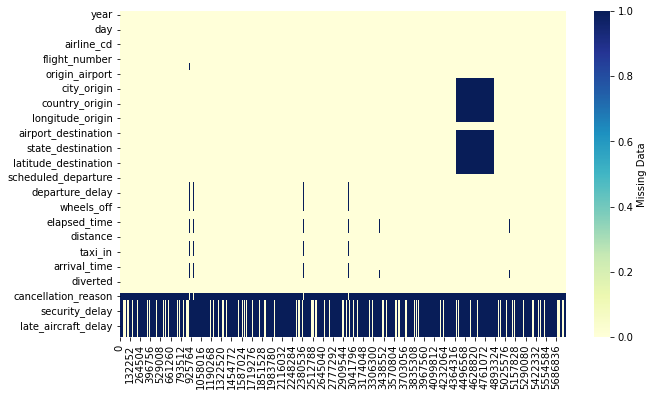

In [28]:
#plotting missing values
# code altered from: https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

> Our team then examined a breakdown of these missing values and noticed that there was a pattern of missing values. In attributes that seem closely related, we see the same number of missing values repeated several times. An example of this is displayed 11 attributes down with `airport_origin` to `country_origin`; all included attributes have exactly 486,165 missing values. This is due to the difference in the flights data set and airports data set having a different number of airport codes and these records will be removed in the next cell.

> The attribute `cancellation_reason` is composed of the recorded reason for a flight's cancellation; the majority of our records were not cancelled and as such, there were no values in this attribute. From our research, we found that the attribute’s filled rows had one of the following entries: A for Airline/Carrier, B for Weather, C for National Air System, and D for Security. With this data understanding, we decided to impute a 5th option which filled the remaining rows with the value `NC`, representing not cancelled. 

In [29]:
#Removing rows where Origin airport is NaN
df = df[df['airport_origin'].notna()]

In [30]:
df.cancellation_reason = df.cancellation_reason.fillna('NC') 

In [31]:
delay_fillna = ['arrival_delay', 'departure_delay', 'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'] 
df[delay_fillna] = df[delay_fillna].fillna(0)  

#### Plotting missing values after imputing for missing and removing rows with a null airport origin

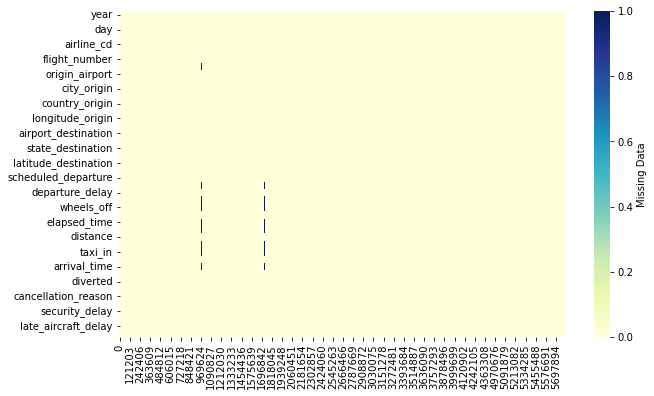

In [32]:
# code altered from: https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

> The last attributes our team addressed are the origin/destination, latitude, and longitude attributes. Our team thought that the missing values for these 2 attributes were particularly weird because of the relatively small difference between the null counts of latitude and longitude and the attribute range starting with `airport_origin`. After sorting the original airport data set by longitude ascending, we discovered that there are 3 airports with missing latitudes and longitudes. As there were only 3 missing coordinates our team found said coordinates, imputed them, and re-ran our merger.   

### Previously run code to impute missing lat/long values 
#### Imputed missing lat/long values from:https://www.airnav.com/airport/

`ECP:`<br>
>   `lat:30.3582408`<br>
>    `long:-85.7956022`<br>

`PGB:`<br>
>    `lat:44.6509444`<br>
>    `long:-73.4681389`<br>

`UST:`<br>
>    `lat:29.9592503`<br>
>    `long:-81.3397292`<br>

`lat_inpute = {`<br>
>    `'ECP': 30.3582408,`<br>
>    `'PBG': 44.6509444,`<br>
>    `'UST': 29.9592503`<br>
` }`<br>

`long_inpute = {`<br>
>    `'ECP': -85.7956022,`<br>
>    `'PBG': -73.4681389,`<br>
>    `'UST': -81.3397292`<br>
`}`<br>


`missing_lat_long = ['ECP','PBG','UST']`<br>

`df_airports['LATITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(lat_inpute)`<br>
`df_airports['LONGITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(long_inpute)`

#### Remaining Missing Values
> As for the remaining missing values we have decided to drop them. The remaining attributes are a combination of categorical, discrete, and 4 numerical attributes that we have decided are too heavily dependent on other attributes to fill in with a mean or median value. Any other numerical variaible with a missing value will later be imputed with a 0 to signify no delay for that variable.

> Since several rows contain the same route information, because airlines have set routes/schedules, we have decided to regard any rows with similar data as a valid part of our data set.  

#### Duplicate records: 

In [33]:
df[df.duplicated()] 

Empty DataFrame
Columns: [year, month, day, day_of_week, airline_cd, airline_name, flight_number, tail_number, origin_airport, airport_origin, city_origin, state_origin, country_origin, latitude_origin, longitude_origin, destination_airport, airport_destination, city_destination, state_destination, country_destination, latitude_destination, longitude_destination, scheduled_departure, departure_time, departure_delay, taxi_out, wheels_off, scheduled_time, elapsed_time, air_time, distance, wheels_on, taxi_in, scheduled_arrival, arrival_time, arrival_delay, diverted, cancelled, cancellation_reason, air_system_delay, security_delay, airline_delay, late_aircraft_delay, weather_delay]
Index: []

#### Outliers

>  The below boxplots show that our airline data is extremely right skewed. The team will continue to evaluate how to deal with the outliers. The data will need to be transformed before performing any modeling. 

>Several methods of dealing with the outliers within our data currently consist of:

>**1. Keep data as is.**<br>
>**2. Remove any data point that is longer than 360 minutes.**<br>
>**3. Transform data using either a log scale or another scale.**

> If we were to transform the data in any way, we would need to consider intrepretability of the output of models and graphs.

***

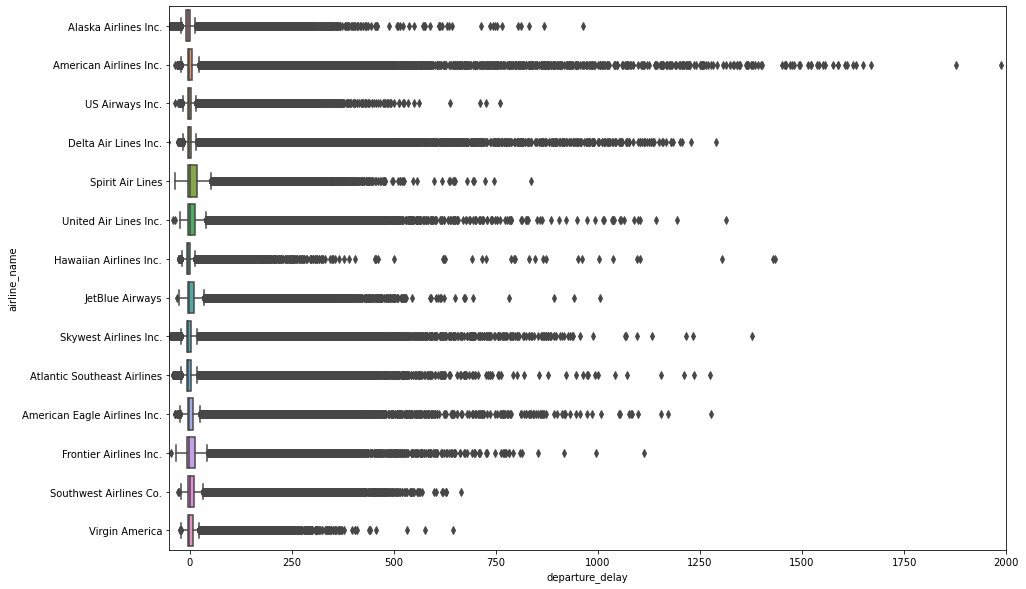

In [34]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="departure_delay",y='airline_name') 
plt.xlim(-50, 2000); 

# Simple Statistics

> For the simple statistics, we removed any column that was a numeric but served as a categorial variable. This removed fields such as year, month, day and flight number. After removing these columns, we produced some simple statistics on the remaining columns such as count, mean, min, standard deviation and 5 number summary. Within the data set while we determined that there are plenty of outliers, none of the data points look to be typos or out of place.  After reviewing these descriptive statistics, we plotted any columns that were used in our model.

In [35]:
numeric_cols = df.select_dtypes(include = np.number).columns
df_stats = df[numeric_cols]

#dropping categorical numeric columns
cat_num_cols = ['year','month','day','day_of_week','flight_number','latitude_origin','longitude_origin','latitude_destination','longitude_destination','diverted','cancelled']
df_stats = df_stats.drop(columns = cat_num_cols)

In [36]:
df_stats.describe()

scheduled_departure  departure_time  departure_delay      taxi_out  \
count         5.332914e+06    5.249100e+06     5.332914e+06  5.246302e+06   
mean          1.330107e+03    1.336074e+03     9.620947e+00  1.610290e+01   
std           4.843130e+02    4.974114e+02     3.731556e+01  8.991109e+00   
min           1.000000e+00    1.000000e+00    -8.200000e+01  1.000000e+00   
25%           9.170000e+02    9.210000e+02    -5.000000e+00  1.100000e+01   
50%           1.325000e+03    1.331000e+03    -1.000000e+00  1.400000e+01   
75%           1.730000e+03    1.741000e+03     7.000000e+00  1.900000e+01   
max           2.359000e+03    2.400000e+03     1.988000e+03  2.250000e+02   

         wheels_off  scheduled_time  elapsed_time      air_time      distance  \
count  5.246302e+06    5.332908e+06  5.231130e+06  5.231130e+06  5.332914e+06   
mean   1.357926e+03    1.417832e+02  1.371940e+02  1.136654e+02  8.228955e+02   
std    4.990460e+02    7.525171e+01  7.430076e+01  7.229764e+01  6.077992e+02   
min    1.000000e+00    1.800000e+01  1.400000e+01  7.000000e+00  2.100000e+01   
25%    9.350000e+02    8.500000e+01  8.200000e+01  6.000000e+01  3.730000e+02   
50%    1.343000e+03    1.230000e+02  1.190000e+02  9.400000e+01  6.490000e+02   
75%    1.755000e+03    1.740000e+02  1.690000e+02  1.440000e+02  1.065000e+03   
max    2.400000e+03    7.180000e+02  7.660000e+02  6.900000e+02  4.983000e+03   

          wheels_on       taxi_in  scheduled_arrival  arrival_time  \
count  5.242972e+06  5.242972e+06       5.332914e+06  5.242972e+06   
mean   1.471021e+03  7.438059e+00       1.493747e+03  1.475922e+03   
std    5.237584e+02  5.686169e+00       5.079263e+02  5.279477e+02   
min    1.000000e+00  1.000000e+00       1.000000e+00  1.000000e+00   
25%    1.054000e+03  4.000000e+00       1.110000e+03  1.058000e+03   
50%    1.508000e+03  6.000000e+00       1.520000e+03  1.512000e+03   
75%    1.912000e+03  9.000000e+00       1.919000e+03  1.917000e+03   
max    2.400000e+03  2.480000e+02       2.400000e+03  2.400000e+03   

       arrival_delay  air_system_delay  security_delay  airline_delay  \
count   5.332914e+06      5.332914e+06    5.332914e+06   5.332914e+06   
mean    4.792651e+00      2.537649e+00    1.461584e-02   3.556582e+00   
std     3.941143e+01      1.326864e+01    9.460972e-01   2.203969e+01   
min    -8.700000e+01      0.000000e+00    0.000000e+00   0.000000e+00   
25%    -1.300000e+01      0.000000e+00    0.000000e+00   0.000000e+00   
50%    -4.000000e+00      0.000000e+00    0.000000e+00   0.000000e+00   
75%     8.000000e+00      0.000000e+00    0.000000e+00   0.000000e+00   
max     1.971000e+03      1.134000e+03    5.730000e+02   1.971000e+03   

       late_aircraft_delay  weather_delay  
count         5.332914e+06   5.332914e+06  
mean          4.456789e+00   5.608581e-01  
std           2.094994e+01   9.019633e+00  
min           0.000000e+00   0.000000e+00  
25%           0.000000e+00   0.000000e+00  
50%           0.000000e+00   0.000000e+00  
75%           0.000000e+00   0.000000e+00  
max           1.331000e+03   1.211000e+03

> After performing some descriptive statistics, the majority of the numerical features are extremely right skewed and we continue to determine the best way to handle these data points. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


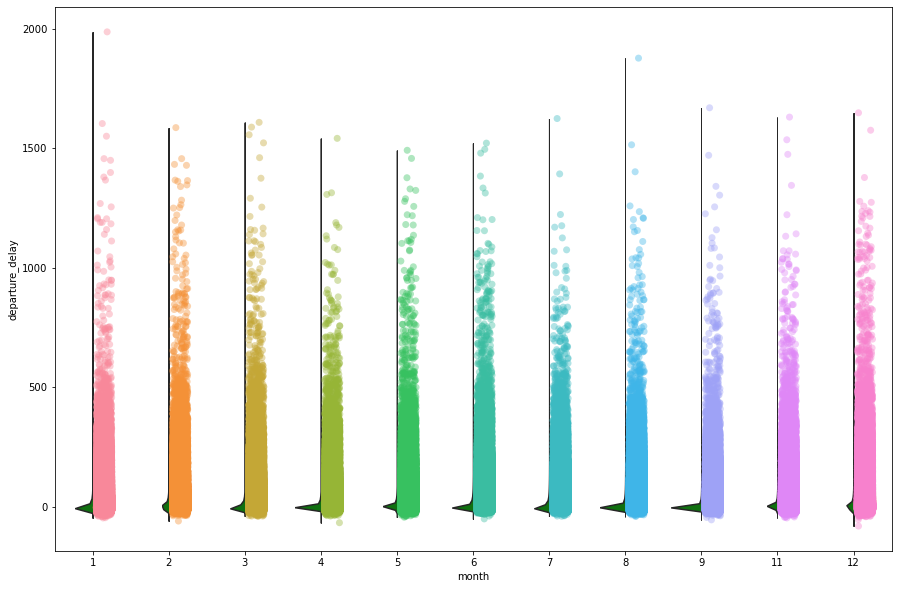

In [37]:
#adapted from online. Can't find website
plt.figure(figsize=(15, 10))
# Create violin plots without mini-boxplots inside.
ax = sns.violinplot(y='departure_delay',
                    x='month',
                    data=df,
                    color='green', 
                    cut=0,
                    inner=None)

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height,
                       transform=ax.transData))

# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
sns.stripplot(y='departure_delay',
              x='month',
              data=df,
              alpha=0.4,
              size=7)

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + 0.15)


plt.legend(frameon=False, fontsize=15, loc='upper left');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


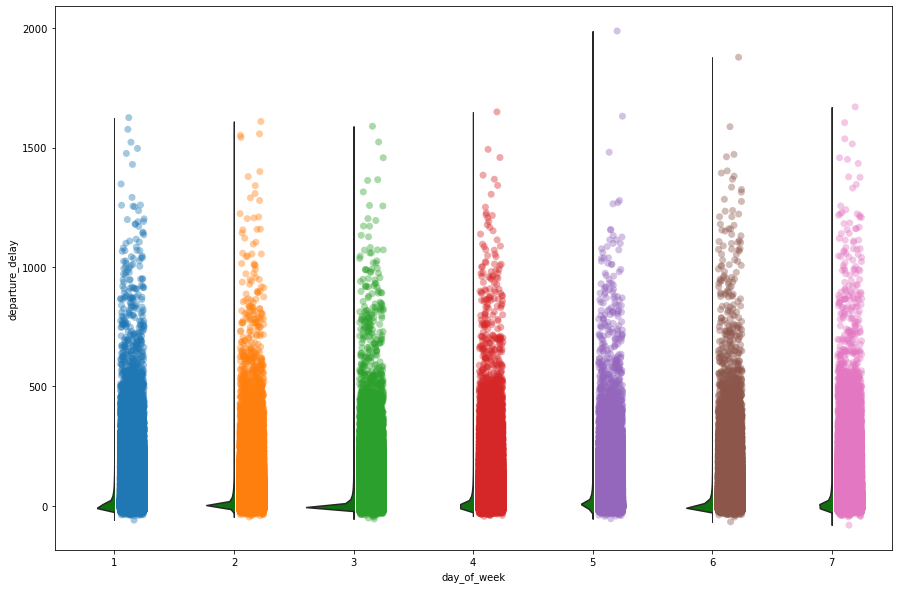

In [38]:
#adapted from online. Can't find website
plt.figure(figsize=(15, 10))
# Create violin plots without mini-boxplots inside.
ax = sns.violinplot(y='departure_delay',
                    x='day_of_week',
                    data=df,
                    color='green', 
                    cut=0,
                    inner=None)

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height,
                       transform=ax.transData))

# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
sns.stripplot(y='departure_delay',
              x='day_of_week',
              data=df,
              alpha=0.4,
              size=7)

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + 0.15)


plt.legend(frameon=False, fontsize=15, loc='upper left');

***

# Visualize Attributes

>One of the attributes the team was interested in visualizing was the numeric response variable, `departure_delay`. The team wanted to look at the distribution of the variable to determine if it was uniform or not. To complete this, the team created a histogram for `departure_delay`. A histogram was chosen as an appropriate visualization as they visually communicate an attribute’s distribution.  

>As evidence below, the distribution of `departure_delay` proved to be right skewed. Knowing that having skewed variables in a model negatively impacts results, (skewed variables don’t meet statistical assumptions for regression), the team log transformed `departure_delay` to see if the distribution was corrected. After log transforming the response, the variable’s distribution was uniform.  

#### Histogram of Departure Delays

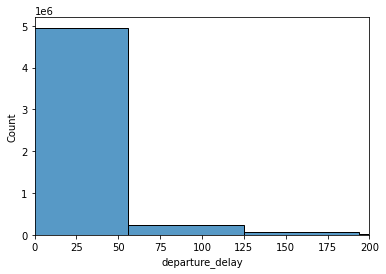

In [39]:
#Creating a histogram of the departure_delay variable. The variable is right skewed.

sns.histplot(data=df, x="departure_delay", bins=30) 
plt.xlim(0, 200); 

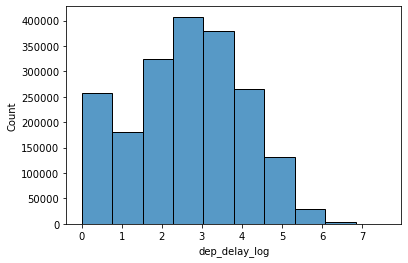

In [40]:
df_deep_delay = df.copy()
#Log transforming the departure delay variable. 
df_deep_delay['dep_delay_log'] = np.log(df['departure_delay']) 

#Distrbution of origin_airport variable.  
sns.histplot(df_deep_delay, x="dep_delay_log",bins=10); 

In [41]:
#creating a df for airlines and delay types 
airlinedelaytype = pd.DataFrame(df.groupby(['airline_name'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index()

airlinedelaytype['total'] = airlinedelaytype['air_system_delay'] + airlinedelaytype['airline_delay'] + airlinedelaytype['late_aircraft_delay'] + airlinedelaytype['weather_delay'] 

airlinedelaytype['pcnt_late_aircraft_delay'] = (airlinedelaytype['late_aircraft_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_airline_delay'] = (airlinedelaytype['airline_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_air_system_delay'] = (airlinedelaytype['air_system_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_weather_delay'] = (airlinedelaytype['weather_delay']/airlinedelaytype['total']) 

#creating a df for months and delay types 
monthdelaytype = pd.DataFrame(df.groupby(['month'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index() 

monthdelaytype ['total'] = monthdelaytype ['air_system_delay'] + monthdelaytype['airline_delay'] + monthdelaytype['late_aircraft_delay'] + monthdelaytype['weather_delay'] 

monthdelaytype ['pcnt_late_aircraft_delay'] = (monthdelaytype ['late_aircraft_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_airline_delay'] = (monthdelaytype['airline_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_air_system_delay'] = (monthdelaytype ['air_system_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_weather_delay'] = (monthdelaytype ['weather_delay']/monthdelaytype ['total']) 

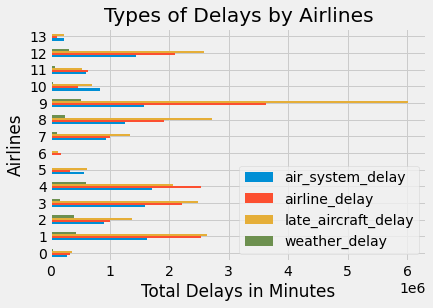

In [42]:
#plotting airlines against delay types 
airlinedelaytype1=airlinedelaytype[['airline_name','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=airlinedelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Airlines") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Airlines");

**Types of Delays by Airlines**: `Airline_delay` and `late_aircraft_delay` have the highest occurences from the types of delays. This makes sense as planes arriving late would contribute to an aircraft departing later than scheduled. Another area to explore would be to see the size of these delays as some airlines may be running magnatudes more than other airlines, giving them more opportunities to run into delays.

| # | Airline | Discussion |
| :--- | :--- | :--- |
|0| Alaska Airlines Inc. | Low delays across all categories |
|1| American Airlines Inc. | High delays across all categories |
|2| American Eagle Airlines Inc.| Moderate delays across all categories |
|3| Atlantic Southeast Airlines | High delays across all categories |
|4| Delta Air Lines Inc. | High delays across all categories |
|5|Frontier Airlines Inc. | Low delays across all categories |
|6| Hawaiian Airlines Inc.| Low delays across all categories |
|7| JetBlue Airways | Moderate delays across all categories |
|8| Skywest Airlines Inc. | High delays across all categories |
|9| Southwest Airlines Co. | High delays across all categories |
|10| Spirit Air Lines | Moderate delays across all categories |
|11| US Airways Inc | Moderate delays across all categories |
|12| United Air Lines Inc.| High delays across all categories |
|13| Virgin America | Low delays across all categories |

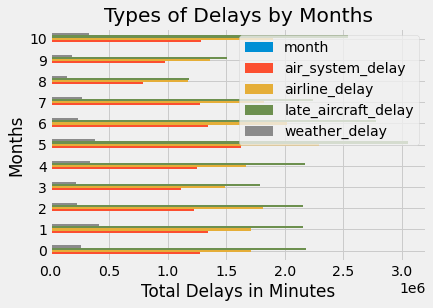

In [43]:
#Plotting Months Against Delay types 
monthdelaytype1=monthdelaytype[['month','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=monthdelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Months") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Months"); 

**Types of Delays by Month Chart** : By summing the total minutes for the types of delays per airline and per month we get similar trend in both charts where `late_aircraft_delay` and `airline_delay` have the largest total of delay minutes. We hypothesize that that system and mechanical issues are less likely to play influence flight delay than operating procedures. When we pair this with the most flights happen (starting at 5am) we theorize that once an airline is delayed, it will continue to try to play catch up throughout the day. This can be mitigated by plane speed but if standard operating procedures are not in place it is highly unlikely that an airline will get back on schedule. As the amount of flights decrease from 5a to 12a, this gives less opportunities for flights make up lost time which compounds the issue but could be an explanation why there are a lot of flights that have delays of less than 5 minutes.

| # | Month| Discussion |
| :--- | :--- | :--- |
| 0 | January | Moderate delays across all categories |
| 1 | February | Moderate delays across all categories |
| 2 | March | Moderate delays across all categories |
| 3 | April | Moderate delays across all categories |
| 4 | May | Moderate delays across all categories |
| 5 | June | High delays across all categories |
| 6 | July | High delays across all categories |
| 7 | August | High delays across all categories |
| 8 | September | Moderate delays across all categories |
| 9 | October | Moderate delays across all categories |
| 10 | November | Moderate delays across all categories |
| 11 | December | High delays across all categories |

#### Map of US Airports and Total Delay Counts

> The heatmap below provides an overview of total delays for each airport in the US. The data points are not standardized across to handle comparisons across smaller and larger airports. Standardization of data points is done at a later stage before modeling.

In [44]:
# create a function for delayed count for Map of US
def delayed_count(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_delayed_cnt = df.copy()
df_delayed_cnt['Delayed_Count'] = df.loc[:,'departure_delay'].apply(delayed_count)

In [45]:
#create smaller data set for plotly
gb_cols = ['latitude_origin','longitude_origin','airport_origin']
df_plotly = pd.DataFrame(df_delayed_cnt.groupby(gb_cols).agg({'Delayed_Count': 'sum'})).reset_index()

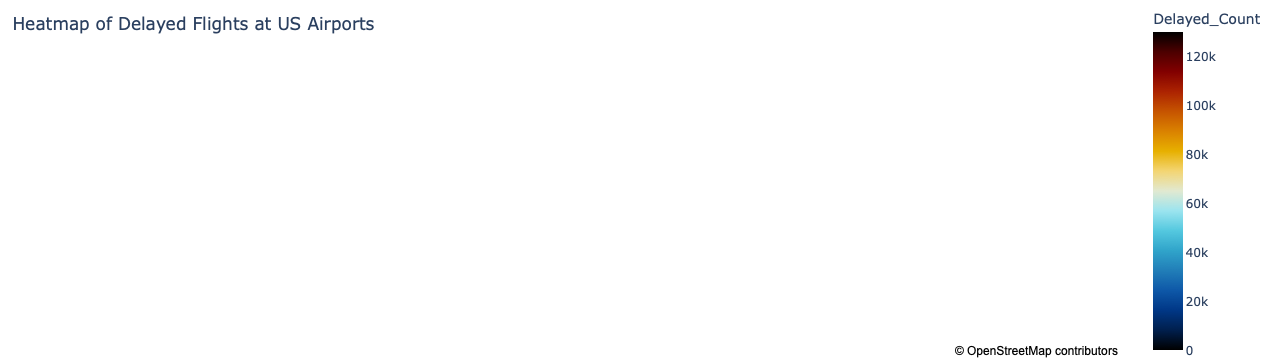

In [46]:
#code altered from https://stackoverflow.com/questions/45678022/build-interactive-map-from-python
fig = px.scatter_mapbox(df_plotly, 
                        lat="latitude_origin",
                        lon="longitude_origin",
                        color="Delayed_Count", 
                        size="Delayed_Count",
                        title = 'Heatmap of Delayed Flights at US Airports',
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        hover_data={'airport_origin':True,
                                    'longitude_origin':True,
                                    'latitude_origin':True,
                                    'Delayed_Count':True},
                        zoom = 3)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    title_x=0.01,
    title_y=0.95,
    margin={"l": 0, "r": 0, "b": 0, "t": 0}
)


fig.show()

#### Combination Plot to show Skewness of Data
> The below combination plot is used to determine look and feel of the skewness of delays across airlines. With the violin plot on the left, we are able to determine the majority of departures are well within a reasonable departure time, however each airline is severely right skewed and will have multiple outliers.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


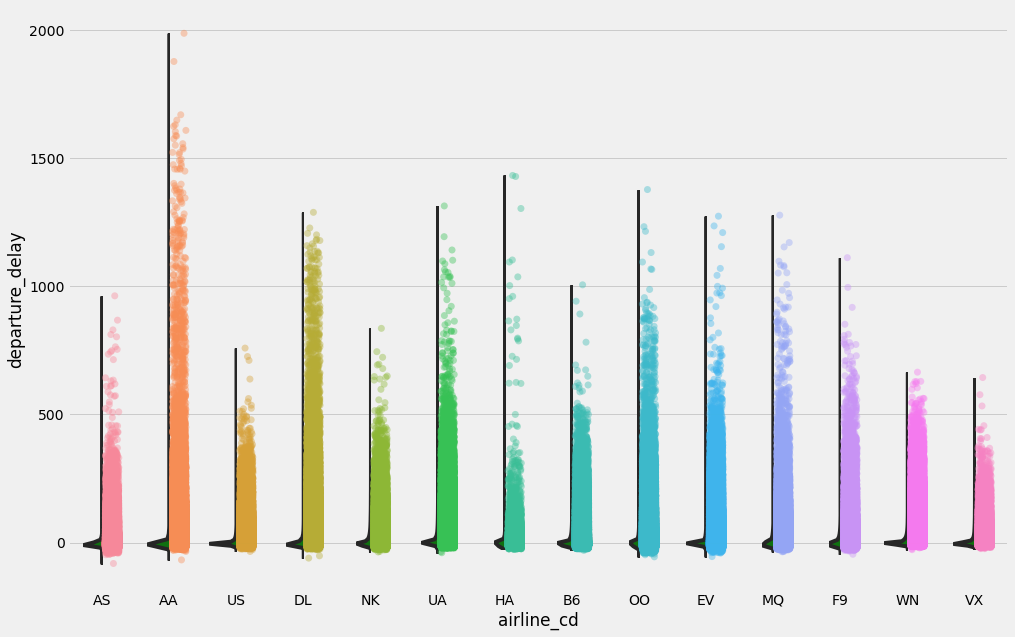

In [47]:
#adapted from online. Can't find website
plt.figure(figsize=(15, 10))
# Create violin plots without mini-boxplots inside.
ax = sns.violinplot(y='departure_delay',
                    x='airline_cd',
                    data=df,
                    color='green', 
                    cut=0,
                    inner=None)

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height,
                       transform=ax.transData))

# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
sns.stripplot(y='departure_delay',
              x='airline_cd',
              data=df,
              alpha=0.4,
              size=7)

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + 0.15)


plt.legend(frameon=False, fontsize=15, loc='upper left');

#### Bar Chart of Average MPH per Airline

>We decided to explore a potential variable that could help mitigate an arrival delay, plane speed. The idea is that departure delay stops cumulating when the plane is in the air and arrival delays will start cumulating until the plane lands. Our assumption is each airline travels at a different speed due to factors like plane models, maintenance practices and weather. Since arrival time is redetermined, if a plane arrives early it is essentially mitigating minutes of delay by minimize `air_time` through plane speed. So it would be possible to have a departure delay but still arrive on time. 

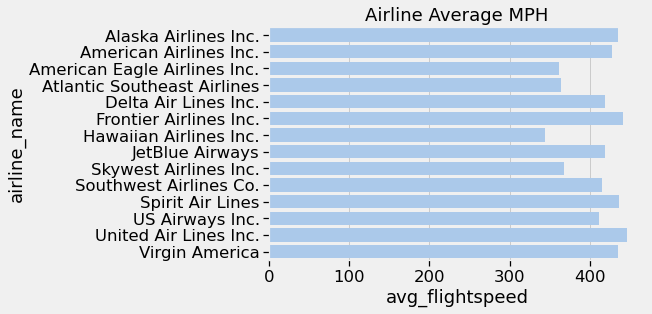

In [48]:
#establish airline flight speed

df_fs = df.copy()
df_fs['flightspeed'] = 60*df["distance"]/df["air_time"]

#setting airline mean speed 
airlinespeed = pd.DataFrame({'avg_flightspeed' : df_fs.groupby(['airline_name'])['flightspeed'].mean()}).reset_index() 
 
#Visualize average speed of each airline 
ax = sns.set_color_codes("pastel") 
sns.set_context("notebook", font_scale=1.5) 
ax = sns.barplot(x="avg_flightspeed", y="airline_name", data=airlinespeed, 
            label="accuracy", color="b").set(title='Airline Average MPH') 

***

# Explore Joint Attributes

>An important consideration the team wanted to evaluate was correlations amongst numeric attributes. To analyze this, the team created a correlation plot of the numeric columns. This plot is helpful to the team as it identifies attributes that have high correlations with each other and it helps the team decide which attributes can be removed from the data set. 

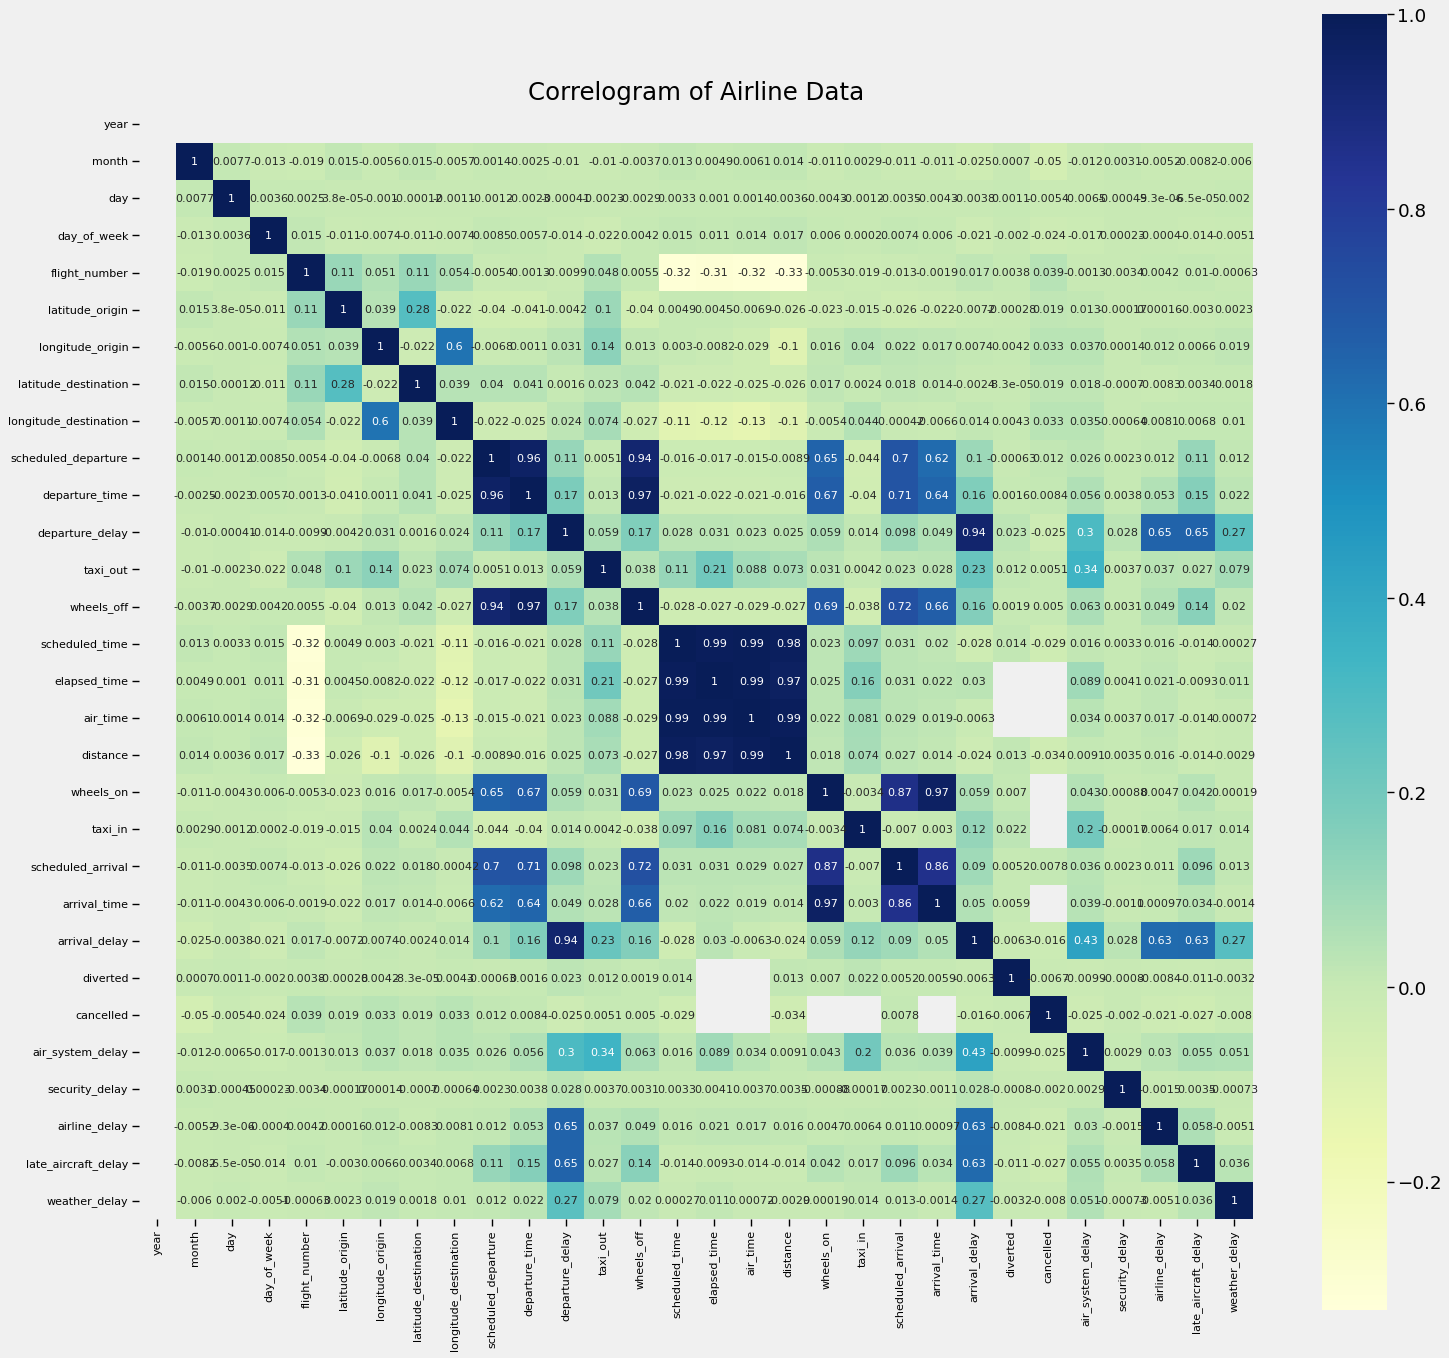

In [49]:
# plotting Correlogram of numerical columns
plt.figure(figsize=(20,20), dpi= 80)
sns.heatmap(df.corr(),
            xticklabels=df.corr().columns,
            yticklabels=df.corr().columns,
            cmap = "YlGnBu",
            square = True,
            annot=True,
            annot_kws={"size":10}
           )

# addting titles and font sizes
plt.title('Correlogram of Airline Data', fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Several takeaways from the correlation plot include: 

> **1. There are 7 attributes with a correlation of .99**<br>
> **2. There are 18 attributes with a correlation > .95**<br>
> **3. There are 22 attributes with a correlation > .90**

>An interesting takeaway from the correlation plot is that there are a lot of highly correlated variables in our data set. Given that our data set contains over five million records, this is to be expected, however, it was nonetheless interesting to see. What the correlation plot tells us about the relationships between our variables is that many of them are dependent upon one another. It is important that the team identify these dependencies and address them before building a final model. 

>After evaluating the correlation plot, the team decided to remove all columns with a correlation > .90. A cutoff of .90 was decided as 22 attributes fall under that classification. Additionally, removal of these columns improves model performance.

>We wanted to visualize the delay types as it makes sense they would directly influence if a flight was delayed (`departure_delay` or `arrival_delay` >0). We wanted to explore our first assumptions that airlines and months would play a significant role in delays.


In [50]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns =to_drop, axis=1)

#### **Total Delays by Airlines and Total Delays per Month Charts**
>By summing the total minutes for the types of delays per airline and per month we get similar trend in both charts where late_aircraft_delay and airline_delay have the largest total of delay minutes. We hypothesize that that system and mechanical issues are less likely to play influence flight delay than operating procedures. When we pair this with the most flights happen (starting at 5am) we theorize that once an airline is delayed, it will continue to try to play catch up throughout the day. This can be mitigated by plane speed but if standard operating procedures are not in place it is highly unlikely that an airline will get back on schedule. As the amount of flights decrease from 5am to 12am, this gives less opportunities for flights make up lost time which compounds the issue but could be an explanation why there are a lot of flights that have delays of less than 5minutes.

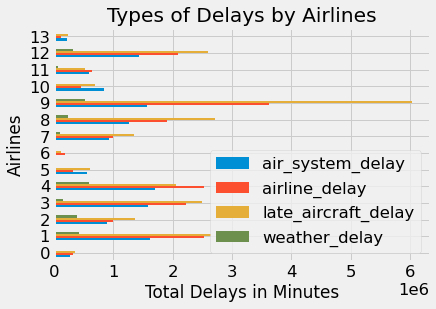

In [51]:
#plotting airlines against delay types 
airlinedelaytype1=airlinedelaytype[['airline_name','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=airlinedelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Airlines") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Airlines"); 

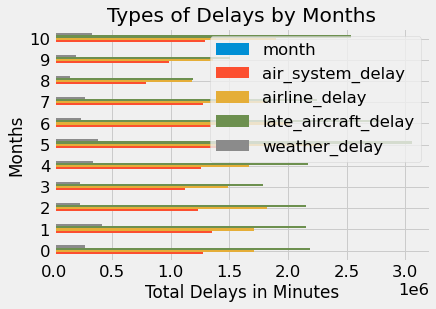

In [52]:
#Plotting Months Against Delay types 
monthdelaytype1=monthdelaytype[['month','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=monthdelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Months") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Months"); 

***

# Explore Attributes and Classes

>After exploring joint relationships in the data set, the team evaluated relationships between attributes and the response variable, `departure_delay`. The intent behind this analysis was to identify what attributes are significant at predicting departure delays.  

>To identify relationships between attributes and the response, the team created box plot visualizations. Box plot visualizations were chosen as they are effective at visualizing relationships between categorical and numeric attributes. Additionally, because box plots show the distribution of attributes, they are effective at identifying relationships. 

>Each box plot contains the log of the response variable on the y-axis and the attribute that is being visualized on the x-axis. A log of `departure_delay` was used as the response was found to be right skewed. After log transforming `departure_delay`, the distribution of the variable was uniform and suitable for analysis.

>The first relationship the team explored was between the variables: `airline` and `dep_delay_log`. From the box plot we see that there is not a strong relationship between the two variables. The team arrived at this conclusion because the mean value of each airline is not increasing as `dep_delay_log` increases. Conversely, the mean of each airline is not decreasing as `dep_delay_log` decreases. From an EDA perspective this indicates that the airline variable is not significant at predicting our response and it can be removed from our data set. Removal of this attribute is something the team will consider in upcoming labs.  

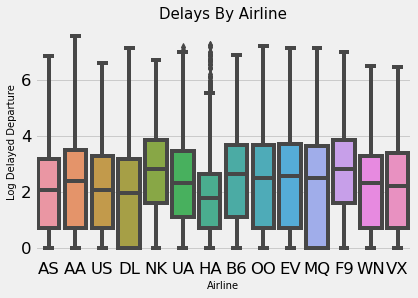

In [53]:
#airline and log_departure_delay boxplot 
sns.boxplot(x = 'airline_cd', y = 'dep_delay_log', data = df_deep_delay) 
plt.title('Delays By Airline', fontsize=15) 
plt.xlabel('Airline', fontsize=10) 
plt.ylabel('Log Delayed Departure', fontsize=10);

>The second relationship the team explored was between the variables: `state_origin` and `dep_delay_log`. Given that there is no positive or negative correlation between the two variables shown, the team concluded that the `state_origin` variable is not significant at predicting the response. Removing this variable will be considered in upcoming labs

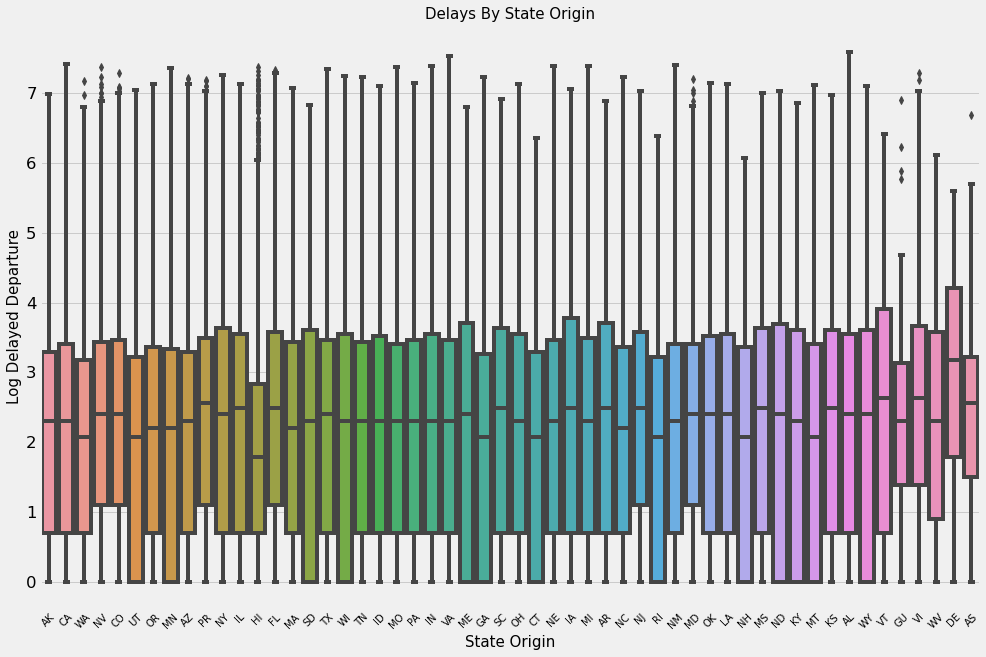

In [54]:
# state_origin by dep_delay_log box plot 
plt.figure(figsize=(15,10)) 
plot = sns.boxplot(x = 'state_origin', y = 'dep_delay_log',data = df_deep_delay) 
plt.title('Delays By State Origin', fontsize=15) 
plt.xlabel('State Origin', fontsize=15) 
plt.ylabel('Log Delayed Departure', fontsize=15) 
plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 10, rotation=45); 

>Next, the team evaluated the relationship between the variables: `desintation_state` and `dep_delay_log`. Subtle variation is shown amongst the means of each state and `log_departure_delay`, however since the variation is not significant enough at producing an increasing or decreasing trend with the response, the team deemed the variable as not significant.   

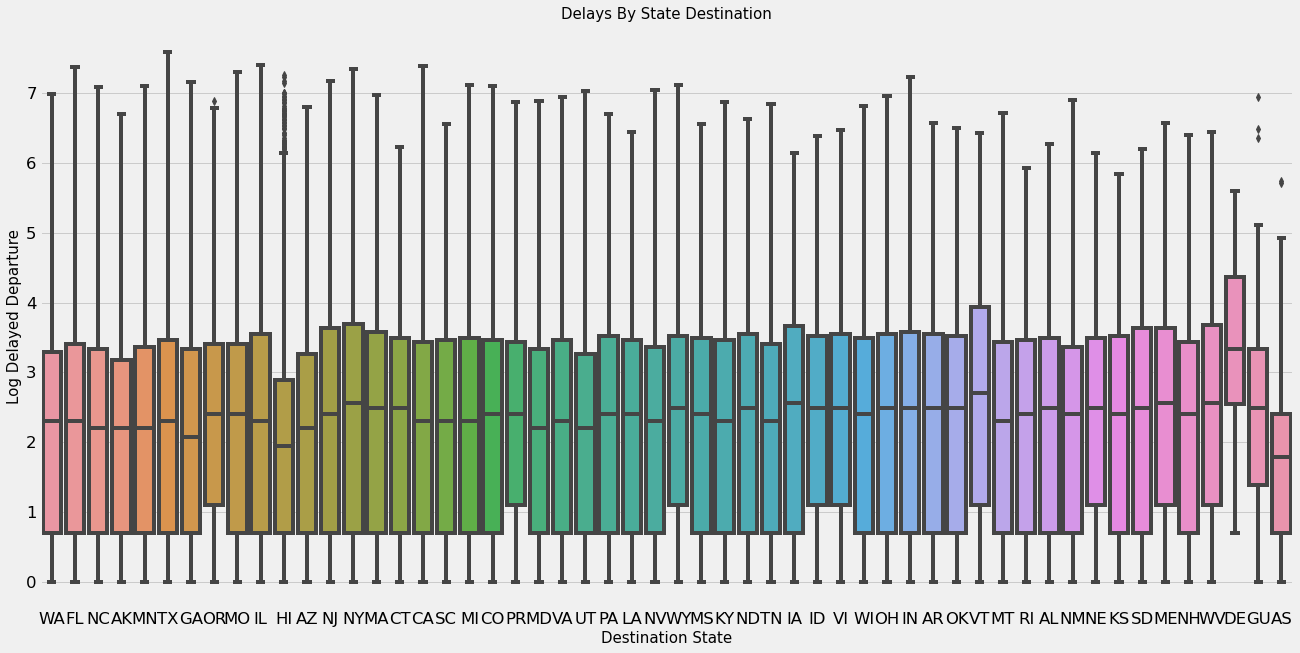

In [55]:
#Boxplot of Delays by State Destination.  
plt.figure(figsize=(20,10)) 
plot = sns.boxplot(x = 'state_destination',y = 'dep_delay_log', data = df_deep_delay) 
plt.title('Delays By State Destination', fontsize=15) 
plt.xlabel('Destination State', fontsize=15) 
plt.ylabel('Log Delayed Departure', fontsize=15); 

>The fourth relationship examined was between the variables: `day_of_week` and `dep_delay_log`. The variable `day_of_week` was selected as the team initially hypothesized that there would be a relationship between it and the response. Upon creating the visualization, the team’s hypothesis was debunked. There are no positive or negative correlations between the `day_of_week` variable and `dep_delay_log`. This indicates that day of the week is not a significant predictor to include in future models.  

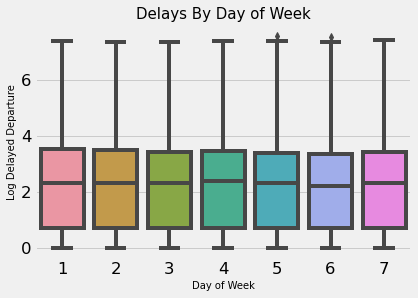

In [56]:
#Boxplot for departure delays by day of week.  
sns.boxplot(x="day_of_week",y = 'dep_delay_log', data = df_deep_delay) 
plt.title('Delays By Day of Week', fontsize=15) 
plt.xlabel('Day of Week', fontsize=10) 
plt.ylabel('Log Delayed Departure', fontsize=10); 

>The last relationship the team examined was between the variables: `month` and `dep_delay_log`. The boxplot showed no strong positive or negative correlations between the two variables. Therefore, the month variable was determined to be a insignificant predictor for our response.  

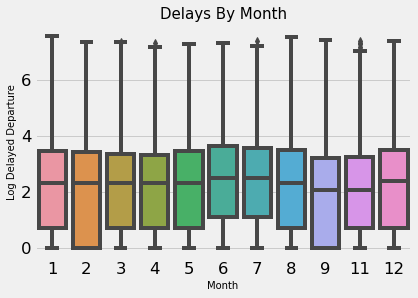

In [57]:
#Boxplot for departure delays by month.  
sns.boxplot(x="month",  y = 'dep_delay_log', data = df_deep_delay) 
plt.title('Delays By Month', fontsize=15) 
plt.xlabel('Month', fontsize=10) 
plt.ylabel('Log Delayed Departure', fontsize=10); 

#### Heatmap Showing Average Time Differece between Departure Time and Actual Time for Airline at Airport

>We created a heatmap on a grid to show airlines and the average delay time at certain cities. We wanted to look at locations as a possible predictor for the departure delay response. From our chart we see that most of the higher delays of greater than 25min are not in the at the larger airports like Atlanta or DFW. Visually we can see some areas have no delays which is most likely due to not having servicing routes to those locations by that airline. The chart supports that that delays have a significant chance of occuring but where the delay happens may influence how long the delay is. Less travelled airports may not have additional planes incase of maintenence issues or the infrastructure to handle quick turnarounds on flights.

In [58]:
#Templated by https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial 
airport_mean_delays = pd.DataFrame(pd.Series(df['city_origin'].unique())) 
airport_mean_delays.set_index(0, drop = True, inplace = True) 
abbr_companies = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict() 
identify_airport = df_airports.set_index('IATA_CODE')['CITY'].to_dict() 
  
# function that extract statistical parameters from a groupby object: 
def get_stats(group): 
    return {'min': group.min(), 'max': group.max(), 
            'count': group.count(), 'mean': group.mean()} 
  
for carrier in abbr_companies.keys(): 
    fg1 = df[df['airline_cd'] == carrier] 
    test = fg1['departure_delay'].groupby(df['city_origin']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

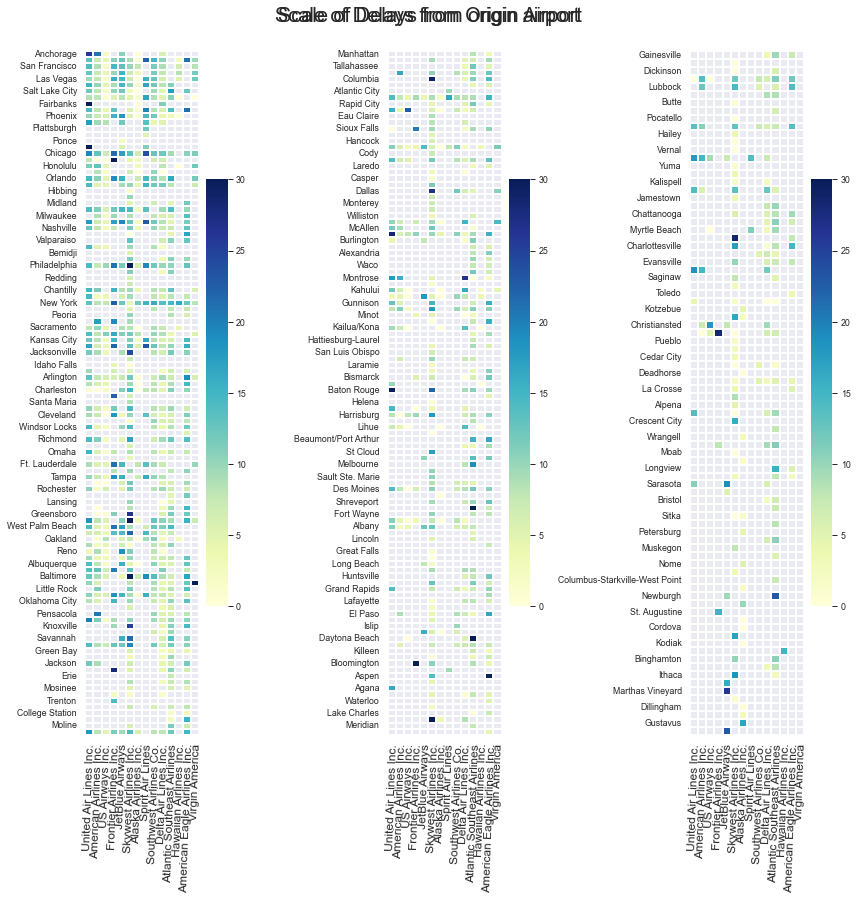

In [59]:
sns.set(context="paper") 
delayscale = plt.figure(1, figsize=(18,18)) 
  
ax = delayscale.add_subplot(1,3,1) 
subset = airport_mean_delays.iloc[:110,:].rename(columns = abbr_companies) 
subset = subset.rename(index = identify_airport) 
mask = subset.isnull() 
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30) 
plt.setp(ax.get_xticklabels(), fontsize=14, rotation = 88) ; 
ax.yaxis.label.set_visible(False) 
  
ax = delayscale.add_subplot(1,3,2)     
subset = airport_mean_delays.iloc[111:221,:].rename(columns = abbr_companies) 
subset = subset.rename(index = identify_airport) 
delayscale.text(0.5, 1.02, "Scale of Delays from origin airport", ha='center', fontsize = 20) 
mask = subset.isnull() 
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30) 
plt.setp(ax.get_xticklabels(), fontsize=14, rotation = 88) ; 
ax.yaxis.label.set_visible(False) 
plt.tight_layout() 

ax = delayscale.add_subplot(1,3,3)     
subset = airport_mean_delays.iloc[222:331,:].rename(columns = abbr_companies) 
subset = subset.rename(index = identify_airport) 
#delayscale.text(0.5, 1.02, "Scale of Delays from Origin Airport", ha='center', fontsize = 20) 
mask = subset.isnull() 
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30) 
plt.setp(ax.get_xticklabels(), fontsize=14, rotation = 88) 
ax.yaxis.label.set_visible(False) 
plt.tight_layout(); 

***

# New Features

> After analyzing the 2015 airline departure delay data set from Kaggle, the team discovered that adding additional attributes would be helpful in understanding the data and maximizing the quality of predictions made. The team has compiled a list of additional attributes that could be added to the 2015 airport delay data set. Below is a list of these attributes, along with their descriptions and use cases.

| # | Feature Addition | Description | Use Case |
| :--- | :--- | :--- |:--- |
| 1 | Aircraft Model | Plane Models  | This could be used to better understand flight efficiency based on age of and plane sophistication |
| 2 | Maintenance History | Last maintenance check, frequency of tune ups, number of major overhauls | Maintenance history could help determine how fast a plane gets in the air, the speeds it can reach and the turn around from one flight to another |
| 3 | Customer Satisfaction Score | We imagine a survey score on different categories like comfort, entertainment, etc | Customer satisfaction scores could be used to target high priority issues the resolve. An example would be If customers rated the flight with a low timeliness score, turn-around procedures would be identified and reviewed |
| 4 | Pilot Years of Experience | Measured in years or months,  could be categorized by position title  | Our assumption is pilot years of experience may influence how long it takes to get planes off the ground and how they handle weather or flight routes |
| 5 | Flight Costs | Measured in Dollars | This could be a measure for airlines that have little to no delay. Our assumption is punctuality and timeliness could influence consumer trust in an airline, the higher the demand would then in turn result in a higher price. Finding that influences flight costs may be correlated with flight efficiency |
| 6 | Flight Weight | Numeric: in lbs or kg  | Our assumption is a heavier plane takes longer to load and could influence the flight speed which would influence departure and arrival delays  |

***

# Exceptional Work

>For our exceptional work section, we decided to run a baseline logistic regression model so that we can compare a base model to a more complex model in the future such as XGBoost or LightGBM

>Since the data set is quite large and personal laptops will struggle to churn through the amount of rows and columns, we decided to filter down the data to Dallas-Fort Worth International Airport. This decreased the data frame size from almost 6 million rows to just under 240k rows and also helped with the one hot encoding below.

In [60]:
#limit data frame for logistic regression to DFW
airports = ['DFW']

df_air = df.loc[df['origin_airport'].isin(airports)]

In [61]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

>Because we want to predict if an airplane is going to be delayed or not using logistic regression, we created a new field called `is_delay` from the `departure_delay` field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

In [62]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

>After creating the `is_delay` field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400. 

In [63]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [64]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

>Once the target variable was created and we one hot encoded the data set, we were able to begin modeling our data. To start, we separated the features with the target varibale as to not leave the response in a test or train data set.

In [65]:
#remove target variable from training data set
feature_cols = final_df.loc[:, final_df.columns != 'is_delay'].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

>From sklearn, we used their train_test_split package to create a 75/25 train and test split for our model.

In [66]:
#split dataset in features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

>After one hot encoding, for our logistic regession model to run, we imputed the NaN values with 0.

In [67]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [68]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (179663, 3397) 

X_test shape:  (59888, 3397) 

y_train shape:  (179663,) 

y_test shape:  (59888,)


>To simplify the code and useability of the model, we used a pipeline function from sklearn to standardize (using StandarScaler), run the data through PCA and then finally a logistic regession model using the PCA output. 

In [69]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

tolerance = 0.1
l1ratio = 1
rs = 0

# Scale -> PCA -> LR 
logistic = LogisticRegression(solver = 'saga',
                                random_state = rs,
                                penalty ='elasticnet',
                                l1_ratio = l1ratio,
                                tol = tolerance)

pipe = Pipeline(steps=[("scaler", scaler),
                       ("pca", pca),
                       ("logistic", logistic)]
               )

pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic',
                 LogisticRegression(l1_ratio=1, penalty='elasticnet',
                                    random_state=0, solver='saga', tol=0.1))])

In [70]:
#predict
y_pred=pipe.predict(X_test)

>After creating predictions on our test data set, we pulled metrics to determine how well our model performed. Our base model had an accuracy of 78.45% with a precision of 95.09% and a recall of 49.02%. This model output gives us a good starting point for hypertuing the model and comparison against some more powerful models such as XGBoost or LightGBM. After computing these metrics we then created a confusion matrix heatmap to better visualize how well our model was predicting and where the model could perform better with False Positives and False Negatives.

In [71]:
#Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7844643334223884
Precision: 0.9509528021226984
Recall: 0.4902383419689119


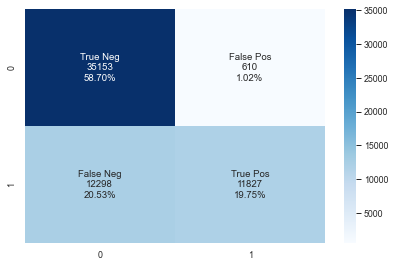

In [72]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

>Finally we chose to plot a ROC curve to visualize specificity and sensitiviy of our model and determine model performance.

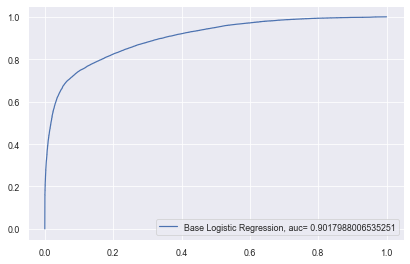

In [73]:
#ROC Curve
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(auc))
plt.legend(loc=4)
plt.show()